In [9]:
import pyxdf
import numpy as np
import xml.etree.ElementTree as ET
import pandas as pd
import matplotlib.pyplot as plt
from pprint import pprint


In [10]:
streams, header = pyxdf.load_xdf('/app/jasmin/data/raw/original/nc726/lsl.xdf')

Stream 5: Calculated effective sampling rate 172.1354 Hz is different from specified rate 200.0000 Hz.


In [11]:
for s in streams:
    name = s['info']['name'][0]
    type = s['info']['type'][0]
    data = np.asarray(s['time_series'])
    print(f"Stream Name: {name}, Type: {type}, Data Shape: {data.shape}")


Stream Name: LiveAmpSN-102101-1018-STETriggerIn, Type: Markers, Data Shape: (0,)
Stream Name: LiveAmpSN-102101-1018-DeviceTrigger, Type: Markers, Data Shape: (0,)
Stream Name: PsychoPyMarker, Type: Markers, Data Shape: (66, 1)
Stream Name: UnixTime_s, Type: Time, Data Shape: (6014, 1)
Stream Name: HwSyncMarker, Type: Markers, Data Shape: (3, 1)
Stream Name: LiveAmpSN-102101-1018, Type: EEG, Data Shape: (2681174, 5)
Stream Name: Neon Companion_Neon Gaze, Type: Gaze, Data Shape: (1055763, 16)
Stream Name: Neon Companion_Neon Events, Type: Event, Data Shape: (4, 1)


In [12]:
amp = next(s for s in streams 
           if s['info']['name'][0] == 'LiveAmpSN-102101-1018')

print("Stream name:", amp['info']['name'][0])
print("\nRaw desc[0]['channels'] structure:")
pprint(amp['info']['desc'][0]['channels'])

Stream name: LiveAmpSN-102101-1018

Raw desc[0]['channels'] structure:
[defaultdict(<class 'list'>,
             {'channel': [defaultdict(<class 'list'>,
                                      {'label': ['respiration'],
                                       'type': ['AUX'],
                                       'unit': ['microvolts']}),
                          defaultdict(<class 'list'>,
                                      {'label': ['gsr'],
                                       'type': ['AUX'],
                                       'unit': ['microvolts']}),
                          defaultdict(<class 'list'>,
                                      {'label': ['ACC_X'],
                                       'type': ['ACC'],
                                       'unit': ['milliGs']}),
                          defaultdict(<class 'list'>,
                                      {'label': ['ACC_Y'],
                                       'type': ['ACC'],
                            

In [13]:
raw = np.asarray(amp['time_series'])
print("raw shape:", raw.shape)
print("times shape:", np.asarray(amp['time_stamps']).shape)

raw shape: (2681174, 5)
times shape: (2681174,)


Respiration Belt is column 0


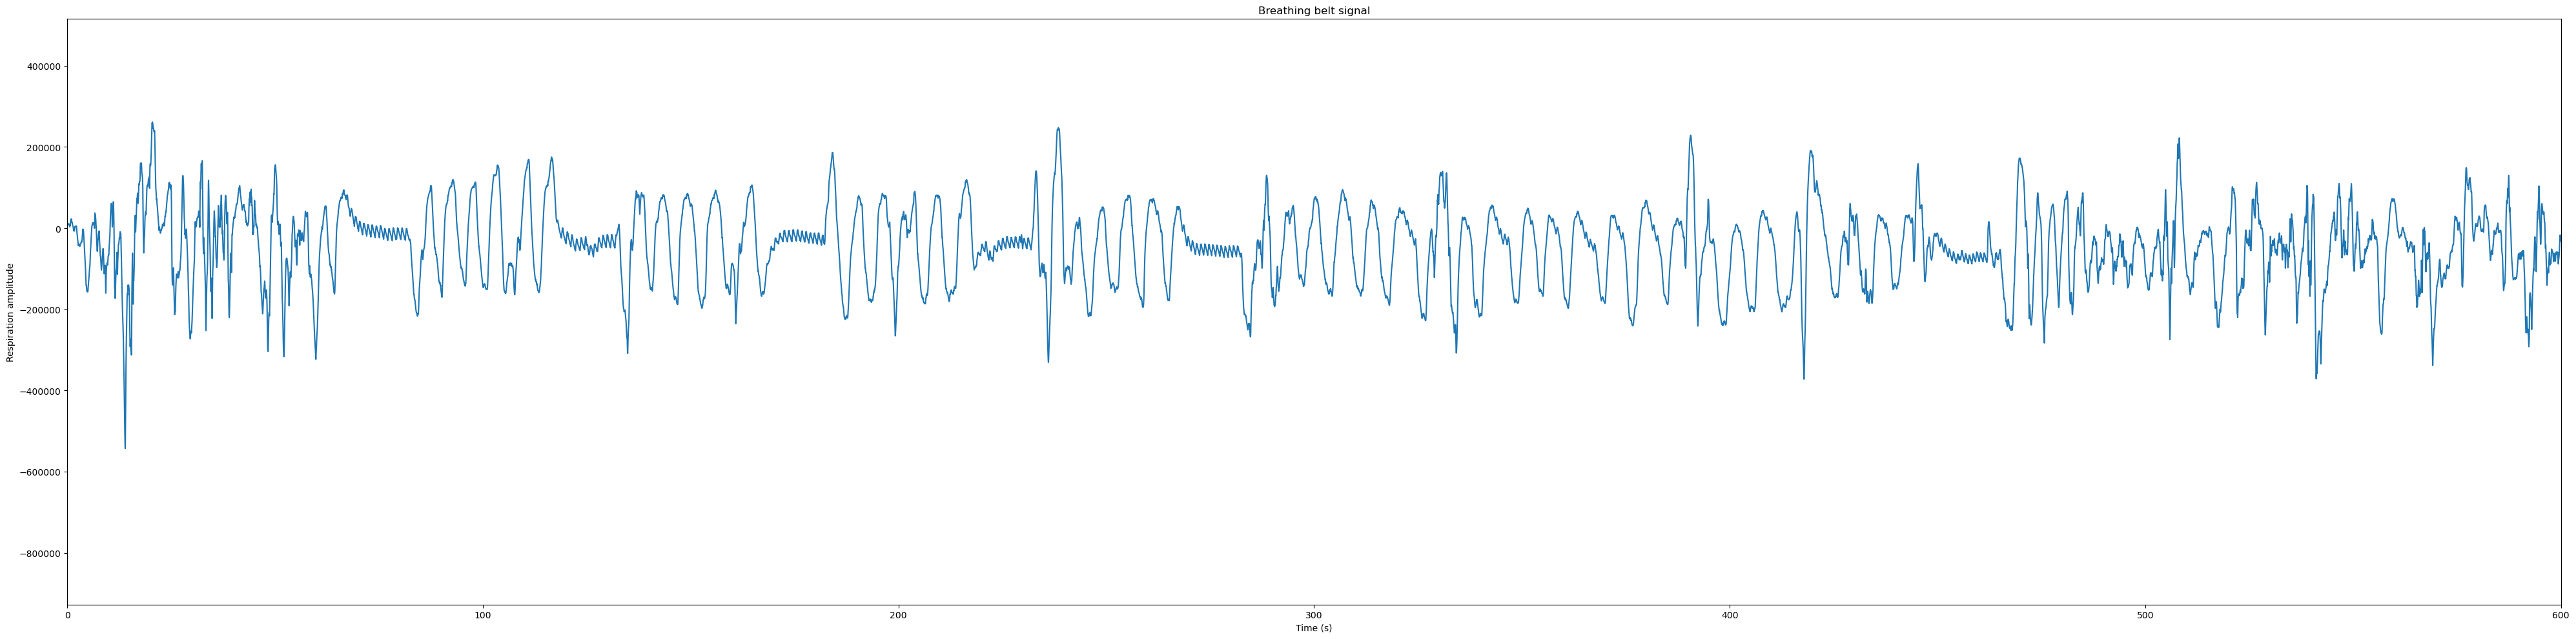

In [23]:
chan_group = amp['info']['desc'][0]['channels'][0]      
chan_list  = chan_group['channel']                     
labels     = [ch['label'][0] for ch in chan_list]     

resp_idx  = labels.index('respiration')  
print("Respiration Belt is column", resp_idx)

times     = np.asarray(amp['time_stamps'])
resp_data = np.asarray(amp['time_series'])[:, resp_idx]


plt.figure(figsize=(40,10))
plt.plot(times - times[0], resp_data)
plt.xlabel('Time (s)')
plt.xlim(0, 600)
plt.ylabel('Respiration amplitude')
plt.title('Breathing belt signal')
plt.tight_layout()
plt.show()

In [15]:
# 1) grab the PsychoPyMarker stream
psy = next(s for s in streams 
           if s['info']['name'][0] == 'PsychoPyMarker')

# 2) build a little DataFrame of timestamps + labels

psy_times   = np.asarray(psy['time_stamps']) - times[0]   # zero-ref to your resp belt
psy_strings = [t[0].lower() for t in psy['time_series']]

df_psy = pd.DataFrame({
    'time':  psy_times,
    'label': psy_strings
})
print(df_psy)


           time             label
0      4.202393       bhb_1_instr
1     67.045320        bhb_1_bh_1
2     82.059640  bhb_1_recovery_1
3    117.071208        bhb_1_bh_2
4    132.087966  bhb_1_recovery_2
..          ...               ...
61  5924.970199  bhb_2_recovery_4
62  5959.980120        bhb_2_bh_5
63  5974.995000  bhb_2_recovery_5
64  6010.003506               end
65  6016.665944                  

[66 rows x 2 columns]


In [16]:
bh_starts = df_psy[df_psy['label'].str.contains(r'_bh_\d+$')]
bh_ends   = df_psy[df_psy['label'].str.contains(r'_recovery_\d+$')]
# split into initial (block 1) vs. final (block 2) holds
bh1_starts = bh_starts[bh_starts['label'].str.startswith('bhb_1')]
bh1_ends   = bh_ends  [bh_ends  ['label'].str.startswith('bhb_1')]
bh2_starts = bh_starts[bh_starts['label'].str.startswith('bhb_2')]
bh2_ends   = bh_ends  [bh_ends  ['label'].str.startswith('bhb_2')]




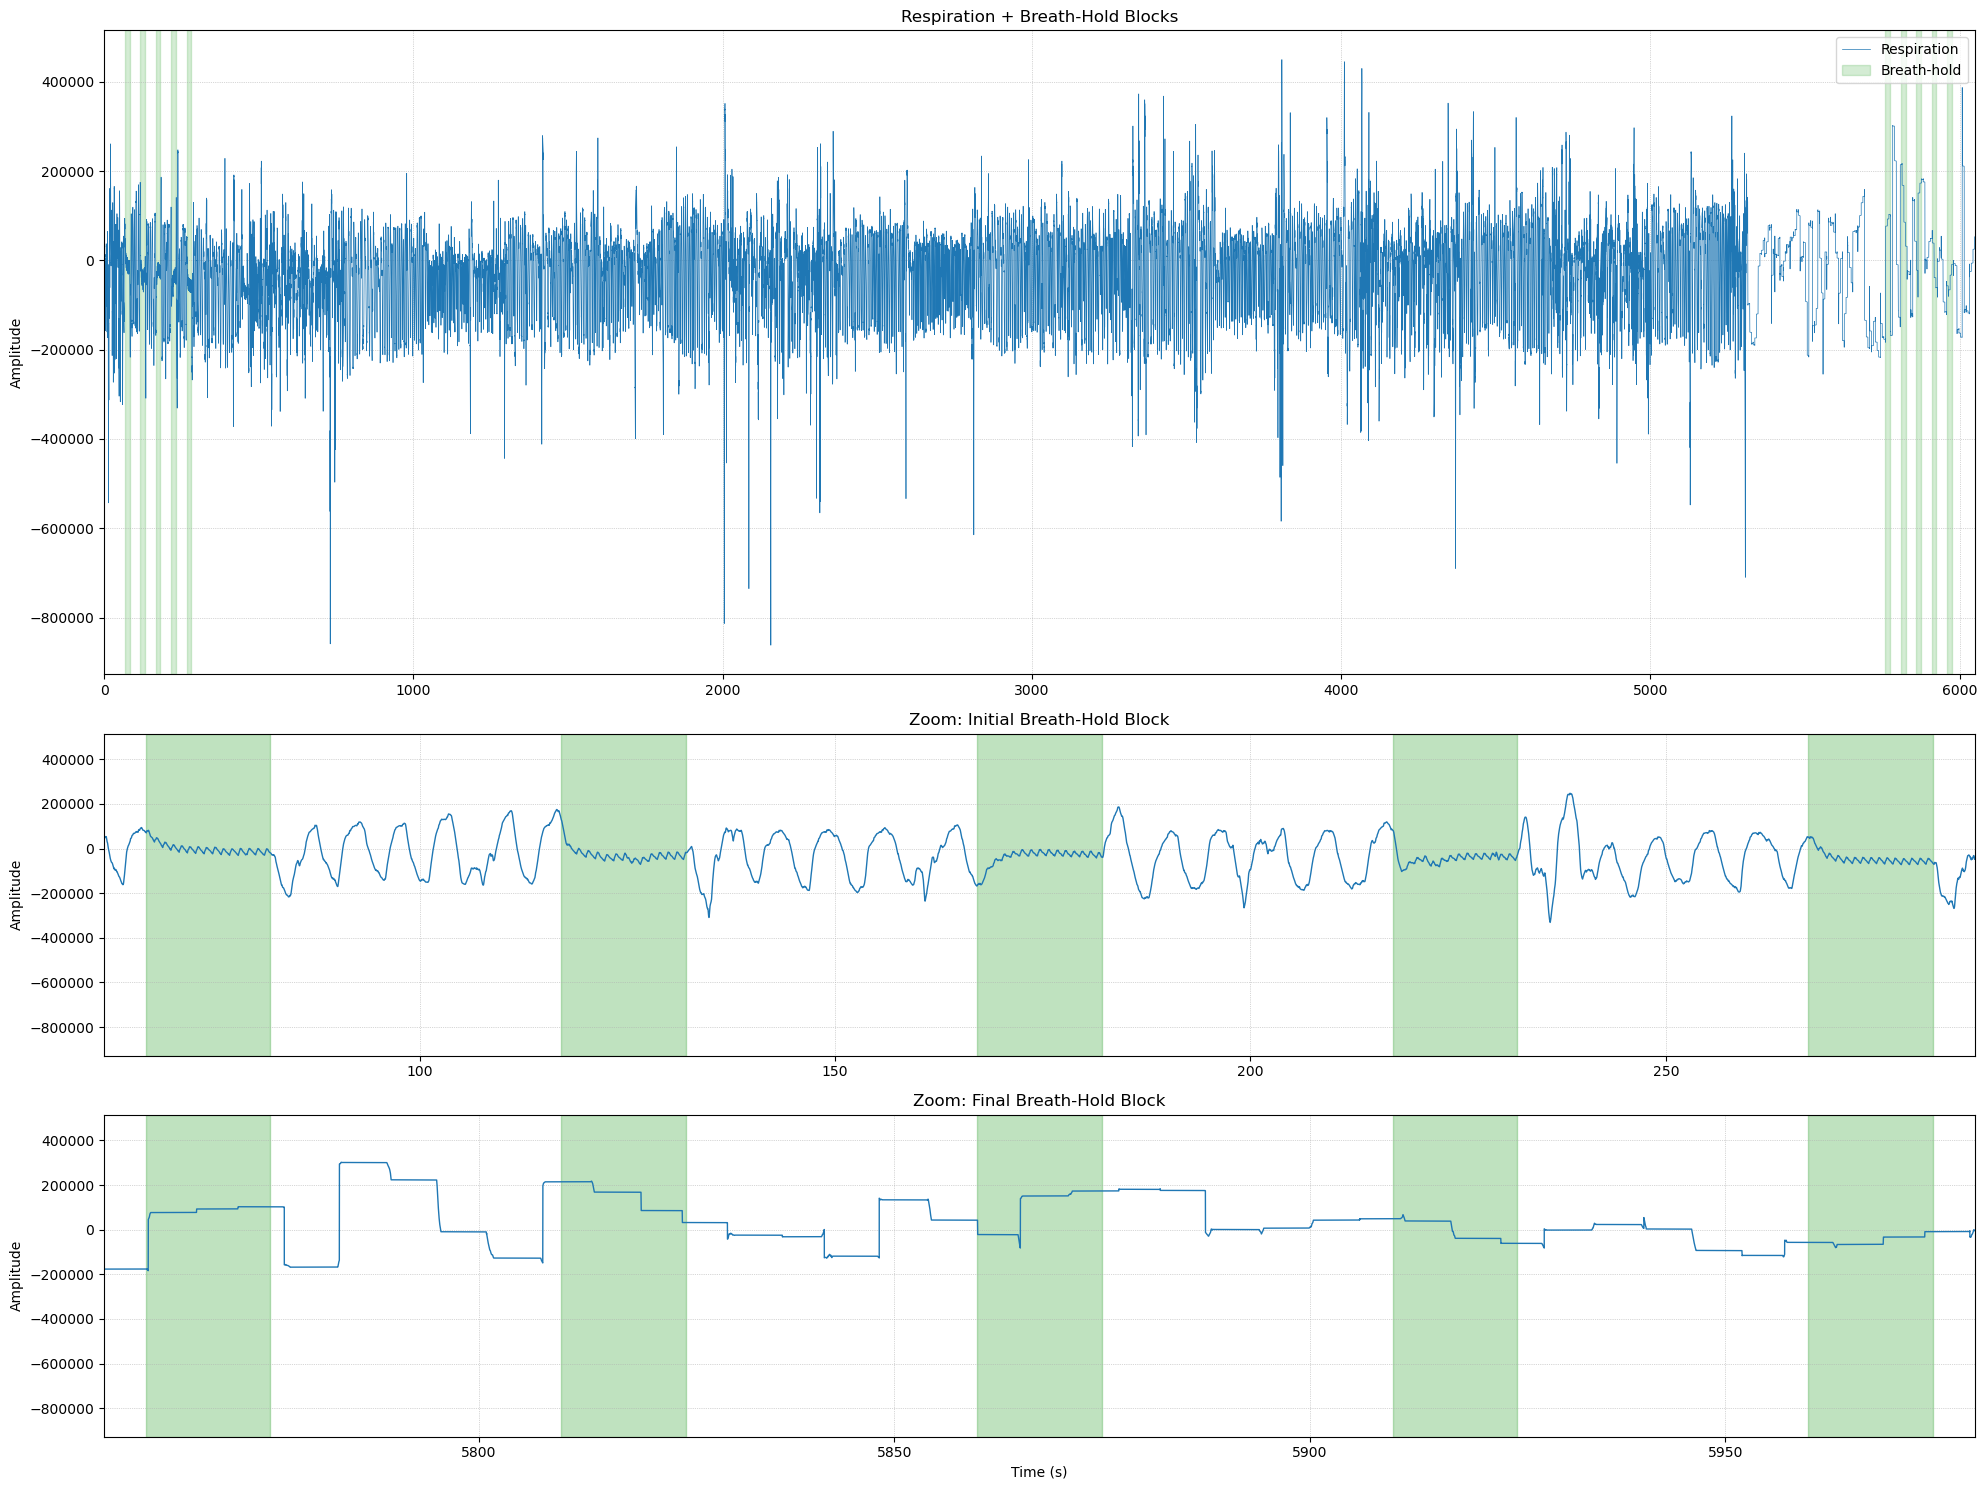

In [25]:
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches

# Prepare relative time and block intervals
rel_times = times - times[0]

# Collect start/end times for both blocks
starts = list(bh1_starts['time']) + list(bh2_starts['time'])
ends   = list(bh1_ends  ['time']) + list(bh2_ends  ['time'])

block1_start, block1_end = min(bh1_starts['time']), max(bh1_ends['time'])
block2_start, block2_end = min(bh2_starts['time']), max(bh2_ends['time'])

# Create a 3-panel figure
fig, (ax_overview, ax_zoom1, ax_zoom2) = plt.subplots(
    3,1, figsize=(20,15),
    gridspec_kw={'height_ratios':[2,1,1]}
)

# 1) Overview: shade every hold→recovery span in green
for s, e in zip(starts, ends):
    ax_overview.axvspan(s, e, color='tab:green', alpha=0.2, zorder=1)

ax_overview.plot(rel_times, resp_data, color='tab:blue', lw=0.5, zorder=2)
ax_overview.set_xlim(0, rel_times[-1])
ax_overview.set_ylabel("Amplitude")
ax_overview.set_title("Respiration + Breath-Hold Blocks")
ax_overview.grid(True, ls=':', lw=0.5)


resp_line  = Line2D([0], [0], color='tab:blue', lw=0.5)
hold_patch = mpatches.Patch(color='tab:green', alpha=0.2)

ax_overview.legend(
    handles=[resp_line, hold_patch],
    labels=['Respiration','Breath-hold'],
    loc='upper right'
)

# 2) Zoom into the initial block
for s, e in zip(bh1_starts['time'], bh1_ends['time']):
    ax_zoom1.axvspan(s, e, color='tab:green', alpha=0.3, zorder=1)

ax_zoom1.plot(rel_times, resp_data, color='tab:blue', lw=1, zorder=2)
ax_zoom1.set_xlim(block1_start - 5, block1_end + 5)
ax_zoom1.set_ylabel("Amplitude")
ax_zoom1.set_title("Zoom: Initial Breath-Hold Block")
ax_zoom1.grid(True, ls=':', lw=0.5)

# 3) Zoom into the final block
for s, e in zip(bh2_starts['time'], bh2_ends['time']):
    ax_zoom2.axvspan(s, e, color='tab:green', alpha=0.3, zorder=1)

ax_zoom2.plot(rel_times, resp_data, color='tab:blue', lw=1, zorder=2)
ax_zoom2.set_xlim(block2_start - 5, block2_end + 5)
ax_zoom2.set_xlabel("Time (s)")
ax_zoom2.set_ylabel("Amplitude")
ax_zoom2.set_title("Zoom: Final Breath-Hold Block")
ax_zoom2.grid(True, ls=':', lw=0.5)

plt.tight_layout()
plt.show()


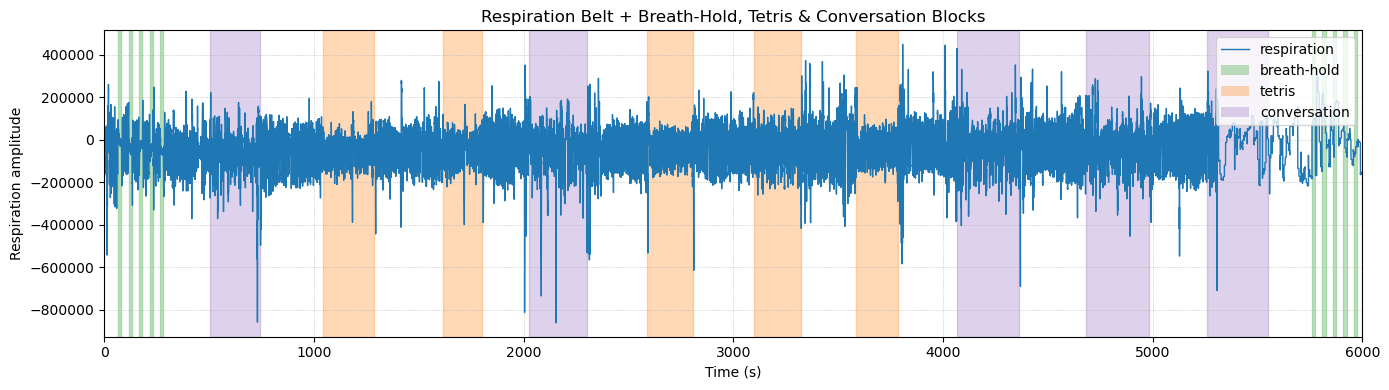

In [43]:
import re
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

# Prepare relative time and data
rel_times = times - times[0]

# 1) Breath‐hold spans (already computed)
bh_starts = list(bh1_starts['time']) + list(bh2_starts['time'])
bh_ends   = list(bh1_ends  ['time']) + list(bh2_ends  ['time'])

# 2) Select only tetris_* and conversation_* start events
mask = df_psy['label'].str.match(r'^(tetris_\d+|conversation_\d+)$')
events = df_psy[mask].copy()
events['group'] = events['label'].str.split('_').str[0]

# assign one color per group
groups = events['group'].unique()
colors = plt.cm.tab10.colors
group_colors = {
    'tetris':      'tab:orange',
    'conversation':'tab:purple'
}

# build overview plot
fig, ax = plt.subplots(figsize=(14,4))

# plot respiration trace
ax.plot(rel_times, resp_data, color='tab:blue', lw=1, label='respiration')

# shade breath‐hold blocks
for s, e in zip(bh_starts, bh_ends):
    ax.axvspan(s, e, color='tab:green', alpha=0.3)

# shade tetris & conversation blocks
for _, row in events.iterrows():
    start = row['time']
    # find the next timestamp in df_psy after this start
    future = df_psy[df_psy['time'] > start]['time']
    end = future.min() if not future.empty else rel_times[-1]
    ax.axvspan(start, end, color=group_colors[row['group']], alpha=0.3)

# build legend
handles = [
    Line2D([0],[0], color='tab:blue', lw=1, label='respiration'),
    Patch(facecolor='tab:green', alpha=0.3, label='breath-hold'),
]
for grp, col in group_colors.items():
    handles.append(Patch(facecolor=col, alpha=0.3, label=grp))

ax.legend(handles=handles, loc='upper right')
ax.set_xlim(0, rel_times[-1])
ax.set_xlabel("Time (s)")
ax.set_ylabel("Respiration amplitude")
ax.set_title("Respiration Belt + Breath‐Hold, Tetris & Conversation Blocks")
ax.grid(ls=':', lw=0.5)
plt.xlim(0, 6000)
plt.tight_layout()
plt.show()

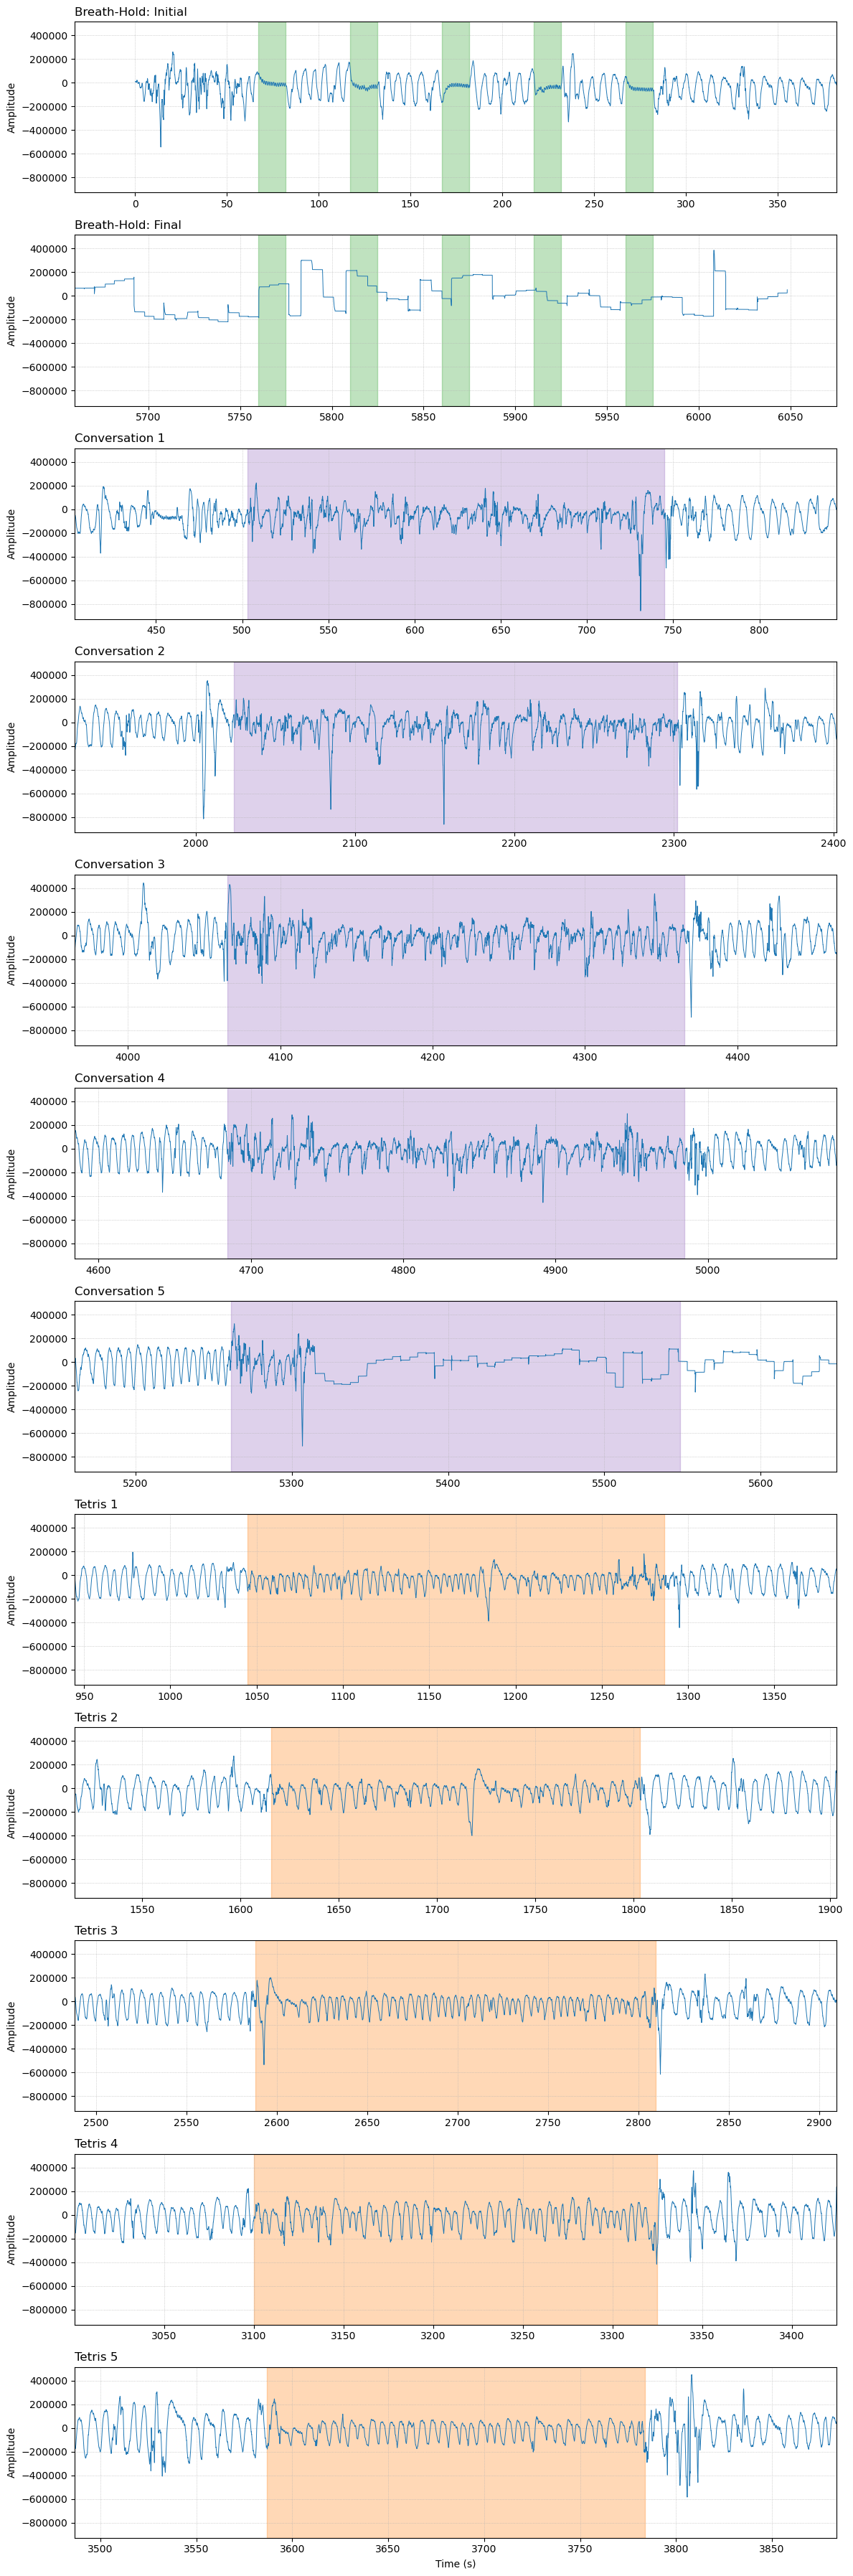

In [40]:
import matplotlib.pyplot as plt

# ========== 1) Build your interval lists ==========

# Breath‐hold pairs (5 holds in each block)
bh1_pairs = list(zip(bh1_starts['time'], bh1_ends['time']))
bh2_pairs = list(zip(bh2_starts['time'], bh2_ends['time']))

# Full-block breath-hold spans for titles
block1_start, block1_end = min(bh1_starts['time']), max(bh1_ends['time'])
block2_start, block2_end = min(bh2_starts['time']), max(bh2_ends['time'])

# Conversation blocks
conv_pairs = []
for _, row in df_psy[df_psy['label'].str.match(r'^conversation_\d+$')].iterrows():
    s = row['time']
    fut = df_psy[df_psy['time'] > s]['time']
    e = fut.min() if not fut.empty else rel_times[-1]
    conv_pairs.append((s, e))

# Tetris blocks
tetris_pairs = []
for _, row in df_psy[df_psy['label'].str.match(r'^tetris_\d+$')].iterrows():
    s = row['time']
    fut = df_psy[df_psy['time'] > s]['time']
    e = fut.min() if not fut.empty else rel_times[-1]
    tetris_pairs.append((s, e))

# ========== 2) Titles & colors ==========

titles = (
    ["Breath-Hold: Initial"] +
    ["Breath-Hold: Final"] +
    [f"Conversation {i+1}" for i in range(len(conv_pairs))] +
    [f"Tetris {i+1}"       for i in range(len(tetris_pairs))]
)

intervals = (
    [(block1_start, block1_end)] +
    [(block2_start, block2_end)] +
    conv_pairs +
    tetris_pairs
)

colors = (
    ["tab:green"]*2 +
    ["tab:purple"]*len(conv_pairs) +
    ["tab:orange"]*len(tetris_pairs)
)

# ========== 3) Plotting ==========

n = len(intervals)   # should be 2 + 5 + 5 = 12
fig, axes = plt.subplots(n, 1, figsize=(12, 3*n), sharex=False)

margin = 100  # seconds before/after for context

for idx, ax in enumerate(axes):
    s, e = intervals[idx]
    title = titles[idx]
    color = colors[idx]

    # 3a) plot full respiration trace
    ax.plot(rel_times, resp_data, color='tab:blue', lw=0.7)

    # 3b) shading
    if idx == 0:
        # initial block: shade each of the 5 holds
        for hs, he in bh1_pairs:
            ax.axvspan(hs, he, color='tab:green', alpha=0.3)
    elif idx == 1:
        # final block: shade each of the 5 holds
        for hs, he in bh2_pairs:
            ax.axvspan(hs, he, color='tab:green', alpha=0.3)
    else:
        # conv or tetris: shade the entire interval
        ax.axvspan(s, e, color=color, alpha=0.3)

    # 3c) zoom window
    ax.set_xlim(s - margin, e + margin)

    # 3d) labels & title
    ax.set_title(title, loc='left')
    ax.set_ylabel("Amplitude")
    ax.grid(ls=':', lw=0.5)

# only the bottom subplot gets the X‐label
axes[-1].set_xlabel("Time (s)")

plt.tight_layout()
plt.show()
